In [5]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

In [1]:
def load_mnist():
    print("Loading MNIST dataset...")

    # Fetch the MNIST dataset from OpenML
    mnist = fetch_openml("mnist_784", version=1, as_frame=False)

    # Extract the data and labels
    # We transpose to make (features, samples) shape- ali clean hunchha
    X = mnist.data.astype(np.float32).T # (784, 70000)
    y = mnist.target.astype(np.int32)

    # Normalize the pixel value to range [0, 1]
    X = X / 255.0

    # One-hot encode the labels
    Y = np.eye(10)[y].T # (10, 70000)

    # Splitting into the training and the testing sets
    # feri split garda transpose garnu parchha kina ki sklearn le (samples, features) ma expect garcha
    X_train, X_temp, Y_train, Y_temp = train_test_split(X.T, Y.T, test_size=0.2, random_state=42)

    #Splitting into validation set from temp set
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

    # Transpose back to (features, samples)
    X_train = X_train.T
    X_val = X_val.T
    X_test = X_test.T   
    Y_train = Y_train.T
    Y_val = Y_val.T
    Y_test = Y_test.T

    print("MNIST dataset loaded successfully!")
    print(f"Training set: X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
    print(f"Validation set: X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
    print(f"Testing set: X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

    return X_train, Y_train, X_val, Y_val, X_test, Y_test
    

In [2]:
np.random.seed(42)

class NeuralNetwork:
    def __init__(self, imput_size=784, hidden_size=128, output_size = 10):
        # Initialize the input sizes, weights and biases
        self.input_size = imput_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.W1 = np.random.randn(self.hidden_size, self.input_size) * np.sqrt(2.0 / self.input_size)

        self.b1 = np.zeros((self.hidden_size, 1))

        self.W2 = np.random.randn(self.output_size, self.hidden_size) * np.sqrt(2.0 / self.hidden_size)

        self.b2 = np.zeros((self.output_size, 1))
        
    # The ReLU activation function
    def relu(self, Z):
        return np.maximum(0, Z)
    
    # Derivation of the ReLU activation function
    def relu_derivative(self, Z):
        return (Z > 0).astype(float)
    
    """ 
    the softmax activation function for the output layer
    we subtract the max value from Z for numerical stability
    we then compute the exponentials and normalize them to get probabilities
    """
    def softmax(self, Z):
        Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
        exp_Z = np.exp(Z_shifted)

        return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    
    def forward_propagation(self, X):
        """
        Perform the forward propagation throught the network
        """
        # z1 = w1x + b1
        Z1 = np.dot(self.W1, X) + self.b1

        # activation function
        A1 = self.relu(Z1)

        # z2 = w2a1 + b2
        Z2 = np.dot(self.W2, A1) + self.b2

        # softmax to the output layer
        A2 = self.softmax(Z2)

        # Store the intermediate values for the backpropagation
        cache = {
            "Z1": Z1,
            "A1": A1,
            "Z2": Z2,
            "A2": A2
        }

        return cache, A2
    
    def compute_loss(self, A2, Y):
        """ 
        Compute the cross-entropy loss
        Parameters:
        A2: Predicted probabilities of shape (output_size, m)
        Y: True labels (one-hoyt-encoded)
        """
        m = Y.shape[1] # number of samples we take from the Y(10, 70000))

        #clip force every value in x to stay between min_value and max_value
        A2_clipped = np.clip(A2, 1e-10, 1.0 - 1e-12)

        # Cross-entropy loss
        loss = -np.sum(Y * np.log(A2_clipped)) / m

        return loss
    
    def backward_propagation(self, X, Y, cache):
        
        # Perform backward propagation to compute gradients.
        # Parameters are: 
        # - X: Input data of shape (input_size, m)
        # - Y: True labels (one-hot) of shape (output_size, m)

        m = X.shape[1] # number of samples we tahke from the X(784, 70000)

        Z1 = cache["Z1"]
        A1 = cache["A1"]
        Z2 = cache["Z2"]
        A2 = cache["A2"]

        # Gradient at output layer
        dZ2 = A2 - Y # (output_size, m)

        # Gradients for W2 and b2
        dW2= np.dot(dZ2, A1.T) /m
        # axis1 does row-wise addition and keepdims keeps 2d shape
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m

        # Gradient at hidden layer
        dA1 = np.dot(self.W2.T, dZ2)
        dZ1 = dA1 * self.relu_derivative(Z1)

        # Gradients for W1 and b1
        dW1 = np.dot(dZ1, X.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m

        gradients = {
            "dW1": dW1,
            "db1": db1,
            "dW2": dW2,
            "db2": db2
        }

        return gradients


    def update_parameters(self, gradients, learning_rate):
        """
        Update the network parameters using gradient descent.
        Parameters:
        - gradients: Dict containing gradients for weights and biases
        - learning_rate: Learning rate for the update step
        """
        self.W1 -= learning_rate * gradients["dW1"]
        self.b1 -= learning_rate * gradients["db1"]
        self.W2 -= learning_rate * gradients["dW2"]
        self.b2 -= learning_rate * gradients["db2"]

    # Make predictions on new data
    def predict(self, X):
        cache,A2 = self.forward_propagation(X)
        return np.argmax(A2, axis=0)        
        
    # Compute accuracy of the model using predicted and true labels
    def compute_accuracy(self, X, Y):
        preds = self.predict(X)
        true_labels = np.argmax(Y, axis=0)
        accuracy = np.mean(preds == true_labels)
        return accuracy



    def train(self, X_train, Y_train, X_val, Y_val,
          learning_rate=0.01, epochs=20, batch_size=64):
    
        m_train = X_train.shape[1]
        num_batches = int(np.ceil(m_train / batch_size))

        history = {
            'train_losses': [],
            'val_losses': [],
            'train_accuracies': [],
            'val_accuracies': []
        }

        for epoch in range(1, epochs + 1):
            # Shuffle
            perm = np.random.permutation(m_train)
            X_sh = X_train[:, perm]
            Y_sh = Y_train[:, perm]

            epoch_loss = 0.0

            # Mini-batches
            for start in range(0, m_train, batch_size):
                end = min(start + batch_size, m_train)
                X_batch = X_sh[:, start:end]
                Y_batch = Y_sh[:, start:end]

                # Forward
                cache, A2 = self.forward_propagation(X_batch)

                # Loss (batch average)
                batch_loss = self.compute_loss(A2, Y_batch)
                epoch_loss += batch_loss

                # Backward & update
                grads = self.backward_propagation(X_batch, Y_batch, cache)
                self.update_parameters(grads, learning_rate)

            # Average epoch loss (over batches)
            epoch_loss /= num_batches

            # Train / Val metrics (full sets)
            # NOTE: these do full forward passes on the datasets
            _, A2_train = self.forward_propagation(X_train)
            train_loss = self.compute_loss(A2_train, Y_train)
            train_acc = self.compute_accuracy(X_train, Y_train)

            _, A2_val = self.forward_propagation(X_val)
            val_loss = self.compute_loss(A2_val, Y_val)
            val_acc = self.compute_accuracy(X_val, Y_val)

            # Save history
            history['train_losses'].append(train_loss)
            history['val_losses'].append(val_loss)
            history['train_accuracies'].append(train_acc)
            history['val_accuracies'].append(val_acc)

            # Print progress every epoch
            print(f"Epoch {epoch}/{epochs} - "
                f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f} - "
                f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

        return history

NameError: name 'np' is not defined

In [ ]:

X_train, Y_train, X_val, Y_val, X_test, Y_test = load_mnist()


Loading MNIST dataset...
MNIST dataset loaded successfully!
Training set: X_train shape: (784, 56000), Y_train shape: (10, 56000)
Validation set: X_val shape: (784, 7000), Y_val shape: (10, 7000)
Testing set: X_test shape: (784, 7000), Y_test shape: (10, 7000)


In [ ]:
nn = NeuralNetwork(imput_size=784, hidden_size=128, output_size=10)

In [ ]:
history = nn.train(
    X_train, Y_train, X_val, Y_val,
    learning_rate=0.1,
    epochs=20,
    batch_size=128
)

Epoch 1/20 - train_loss: 0.2950, train_acc: 0.9153 - val_loss: 0.3140, val_acc: 0.9110
Epoch 2/20 - train_loss: 0.2348, train_acc: 0.9327 - val_loss: 0.2615, val_acc: 0.9267
Epoch 3/20 - train_loss: 0.2003, train_acc: 0.9440 - val_loss: 0.2317, val_acc: 0.9339
Epoch 4/20 - train_loss: 0.1694, train_acc: 0.9514 - val_loss: 0.1998, val_acc: 0.9423
Epoch 5/20 - train_loss: 0.1497, train_acc: 0.9572 - val_loss: 0.1834, val_acc: 0.9484
Epoch 6/20 - train_loss: 0.1363, train_acc: 0.9615 - val_loss: 0.1696, val_acc: 0.9519
Epoch 7/20 - train_loss: 0.1210, train_acc: 0.9663 - val_loss: 0.1554, val_acc: 0.9576
Epoch 8/20 - train_loss: 0.1093, train_acc: 0.9698 - val_loss: 0.1458, val_acc: 0.9600
Epoch 9/20 - train_loss: 0.1030, train_acc: 0.9710 - val_loss: 0.1424, val_acc: 0.9606
Epoch 10/20 - train_loss: 0.0926, train_acc: 0.9741 - val_loss: 0.1336, val_acc: 0.9620
Epoch 11/20 - train_loss: 0.0851, train_acc: 0.9769 - val_loss: 0.1260, val_acc: 0.9640
Epoch 12/20 - train_loss: 0.0797, train_a

In [ ]:
test_acc = nn.compute_accuracy(X_test, Y_test)
print(f"Test accuracy: {test_acc}")


Test accuracy: 0.9748571428571429


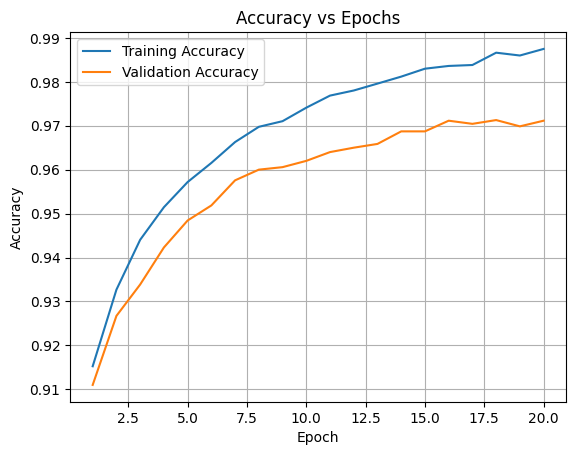

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of epochs
epochs = np.arange(1, len(history['train_accuracies']) + 1)

plt.figure()
plt.plot(epochs, history['train_accuracies'], label='Training Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)

plt.show()


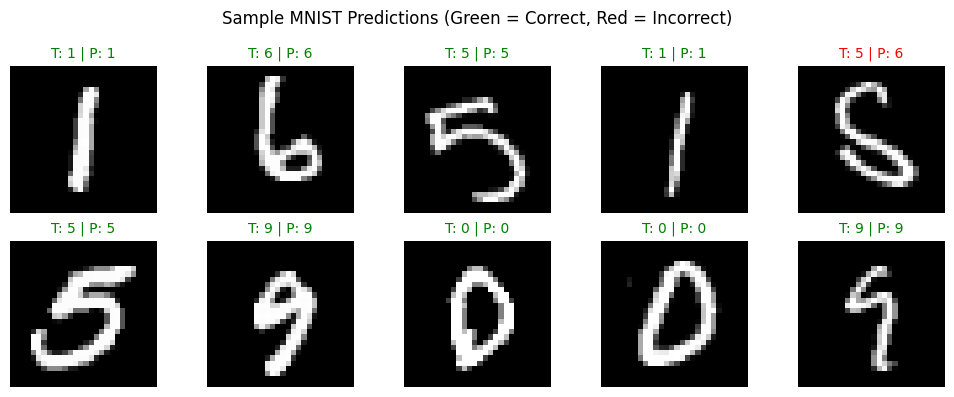

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_predictions(model, X_test, Y_test, num_samples=10):
    # Randomly select samples
    indices = np.random.choice(X_test.shape[1], num_samples, replace=False)

    # Get predictions
    predictions = model.predict(X_test[:, indices])
    true_labels = np.argmax(Y_test[:, indices], axis=0)

    plt.figure(figsize=(10, 4))

    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)

        # Reshape image
        image = X_test[:, idx].reshape(28, 28)

        # Plot image
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        # Color based on correctness
        color = 'green' if predictions[i] == true_labels[i] else 'red'

        plt.title(
            f"T: {true_labels[i]} | P: {predictions[i]}",
            color=color,
            fontsize=10
        )

    plt.suptitle("Sample MNIST Predictions (Green = Correct, Red = Incorrect)")
    plt.tight_layout()
    plt.show()

plot_sample_predictions(nn, X_test, Y_test, num_samples=10)